In [153]:
# Valentin L'HOMEL
# 922110009
# Jupyter: C:\Users\Pival\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\Scripts\jupyter-notebook.exe
#########################

# Code initialization

## Import section

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import math
from random import Random

## Hyperparameters definitions

In [155]:
# Homework defined parameters
NODE_COUNT = 200
EXPONENTIAL_NETWORKS_COUNT = 20
FREE_SCALE_NETWORKS_COUNT = 20

# Personally defined parameters. Changing them mat drastically change the results
MINIMUM_EDGE_WEIGHT = 1
MAXIMUM_EDGE_WEIGHT = 10
EXPONENTIAL_NETWORK_MEAN_DEGREE = 2.5 # Mean degree of a node
# A mean degree of 2.5 is required in order to produce exponential networks with
# more or less the same number of edge than scall-free networks, as in the experiment
EXPONENTIAL_NETWORK_EDGE_PROBABILITY = EXPONENTIAL_NETWORK_MEAN_DEGREE * NODE_COUNT / 2 / (NODE_COUNT * (NODE_COUNT-1) / 2) # Number of edges (mean_degree * node_count / 2) divided by maximum number of edge. This can actually be simplified but I will let it like that
FREE_SCALE_NETWORK_HUB_INIT_DEGREE = 15 # Initial number of connection for a new hub node
FREE_SCALE_NETWORK_HUB_PROBABILITY = 0.1 # Probability a new node will be a hub
RANDOM_SEED = math.ceil(abs( 2021/10/28 - 2021/11/14 )) # That is simply the homeworks dates

## Globals initialization

### Definition of network generators

In [156]:
def generateExponentialNetwork():
    """
    Generate a new exponential network using Erdos-Renyi generative model.

    This create a new network with {NODE_COUNT} nodes, and create edges
    between them according to the probability {EXPONENTIAL_NETWORK_EDGE_PROBABILITY}.

    The graph generated is guaranted to be connected.

    https://github.com/networkx/networkx/blob/main/networkx/generators/random_graphs.py#L111
    """
    G = None
    while True:
        G = nx.erdos_renyi_graph(NODE_COUNT, EXPONENTIAL_NETWORK_EDGE_PROBABILITY, directed=False, seed=random)
        # Connect isolated nodes, if any
        for node in G:
            if (len(list(G.neighbors(node)))) == 0:
                n2 = [n for n in np.random.randint(0, NODE_COUNT, math.floor(EXPONENTIAL_NETWORK_MEAN_DEGREE)) if n != node]
                G.add_edges_from([(node,n) for n in n2] if len(n2) != 0 else [(node,0 if node != 0 else NODE_COUNT-1)])
        # If the graph is still not connected, try again
        if nx.is_connected(G): break
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = random.randint(MINIMUM_EDGE_WEIGHT,MAXIMUM_EDGE_WEIGHT)
    return G

In [157]:
def generateFreeScaleNetwork():
    """
    Generate a new free-scale network following the Barabási–Albert
    preferential attachment model.

    This create a new star-like network with {FREE_SCALE_NETWORK_HUB_INIT_DEGREE}
    nodes, and add either a new node with only one edge, or a new node
    bounds to {FREE_SCALE_NETWORK_HUB_INIT_DEGREE} other nodes with a
    probability of {FREE_SCALE_NETWORK_HUB_PROBABILITY}.
    
    On the Barabási–Albert preferential attachment model, the probability that
    a node is chosen to create an edge is equal to the degree of a node
    divided by the sum of all node's degrees, i.e. twice the current number
    of edges.

    https://github.com/networkx/networkx/blob/main/networkx/generators/random_graphs.py#L687
    """
    G = None
    G = nx.dual_barabasi_albert_graph(NODE_COUNT, 1, FREE_SCALE_NETWORK_HUB_INIT_DEGREE, 1-FREE_SCALE_NETWORK_HUB_PROBABILITY, seed=random)
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = random.randint(MINIMUM_EDGE_WEIGHT,MAXIMUM_EDGE_WEIGHT)
    return G

### Initialization

In [158]:
random = Random(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

exponentials = [generateExponentialNetwork() for _ in range(EXPONENTIAL_NETWORKS_COUNT)]
freeScales = [generateFreeScaleNetwork() for _ in range(FREE_SCALE_NETWORKS_COUNT)]

# Taking 4 random graph on each category for Part B-7 and onward
randomSamplesER = []
randomSamplesSF = []
for i in range(4):
    G = random.choice(exponentials)
    while G in randomSamplesER: G = random.choice(exponentials)
    randomSamplesER.append(G)
    G = random.choice(freeScales)
    while G in randomSamplesSF: G = random.choice(freeScales)
    randomSamplesSF.append(G)

# Part A: Simulate exponential and free-scale networks

## 1. Erdos-Renyi generative model

The Erdos-Renyi generative model initially creates a network with $n$ nodes. It then considers every possible connections between them, and create it accordingly to a probibility $p$.

This allows the creation of an equally distributed network, where the mean degree is equal to $\frac{p \times n}{2}$. This means they have an equivalent degree centrality, and therefore as much importance as each others.

## 3. Scale-free algorithm

Scale-free algorithms, such as the Barabási–Albert preferential attachment model, build an initial network of $m_0$ nodes. Then it adds new nodes with $m$ connections. In that end, it considers every possible edges starting from the new node, and select $m$ of these with a probability equal to the degree of the second node divided by the sum of the degree of every nodes.

This implies that the most connected nodes have a higher probability of being part of a new edge. Therefore, the network will be composed of a few number of nodes with high degree, and a lot of nodes with a degree of one. This also guarantee that the network is connected as long as $m > 0$ and the initial network is also connected.

## 5. Network visualization

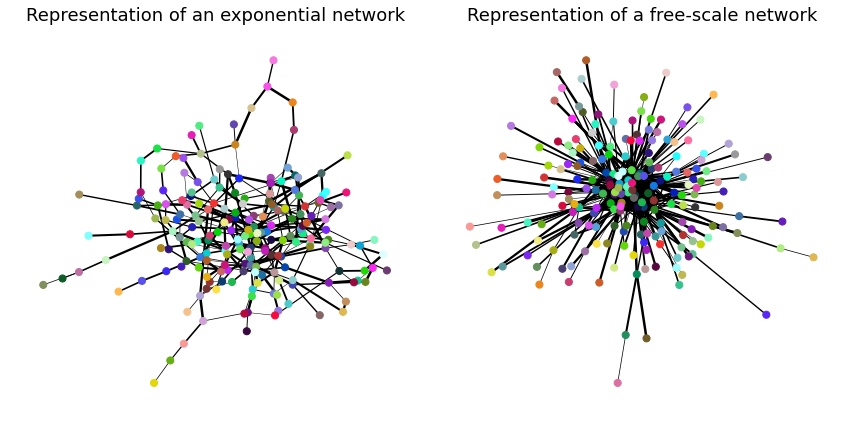

In [159]:
def displayGraph(graph, axis, title):
    options = {
        'ax': axis,
        'node_size': 50,
        'node_color': [(
            # Map the index to a number between 0 and 0xFFFFFF, and decompose it to get RGB values
            ((int(i / NODE_COUNT * 0xFFFFFF) & 0xFF0000) >> 0o20) / 0xFF,
            ((int(i / NODE_COUNT * 0xFFFFFF) & 0x00FF00) >> 0o10) / 0xFF,
            ((int(i / NODE_COUNT * 0xFFFFFF) & 0x0000FF) >> 0o00) / 0xFF,
        ) for i in range(NODE_COUNT)],
        'width': [
            # Set the width between 0.5 and 2.5, depending on the weight of the edge
            0.5 + 2 * (weight-MINIMUM_EDGE_WEIGHT) / (MAXIMUM_EDGE_WEIGHT-MINIMUM_EDGE_WEIGHT)
        for (_,_,weight) in G.edges.data('weight')],
    }
    axis.set_title(title, {'fontsize': 18})
    nx.draw(graph, **options)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
displayGraph(exponentials[0], ax0, "Representation of an exponential network")
displayGraph(freeScales[0], ax1, "Representation of a free-scale network")
fig.tight_layout()
plt.show()

## 6. Distribution of node strength centrality

In [160]:
def drawOverlaidHistogram(elems, nbBars=15, filterMin=0.01, filterMax=0.99, alpha=0.4):
    allValues = [v for (values,_,_) in elems for v in values]
    allValues.sort()
    # Filtering results, ignoring the lowest and highest values
    minValue = allValues[int(len(allValues)*filterMin)]
    maxValue = allValues[int(len(allValues)*filterMax)-1]
    binRange = [minValue + (maxValue-minValue) / nbBars * i for i in range(nbBars)]

    for (values, color, title) in elems:
        plt.hist(values, bins=binRange, weights=[1/len(values)]*len(values), alpha=alpha, color=color, label=title)
    plt.legend()
    plt.show()

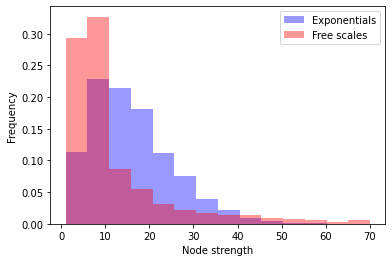

In [161]:
ERWeights = [w for graph in exponentials for (_,w) in graph.degree(weight='weight')]
FSWeights = [w for graph in freeScales for (_,w) in graph.degree(weight='weight')]
plt.xlabel('Node strength')
plt.ylabel('Frequency')
# Filtering at 5% in order to have a better graph
drawOverlaidHistogram([(ERWeights, 'blue', 'Exponentials'), (FSWeights, 'red', 'Free scales')], filterMax=0.95)

We can see on the above graph that exponentials networks have the majority of their nodes (~65%) with a strength greater than 10, that is with assuredly more than one edge, as the maximum strength for an edge is 10. We can also see that the distribution is quite homogeneous, with most nodes (~60%) with a strength between 5 and 20, and almost no nodes with a strength greater than 40. This means that more than halves the nodes have an equivalent influence on the networks, and equally participate to the transfer of informations.

On the free-scales networks, we can see a very high number of nodes (~60%) with a strength lower than or equal to 10, which is the maximum possible weight for an edge. We can also notice that a low number of nodes (~25%) have a strength greater than 20, that is with at least 3 neighbors, and the more the strength, the less nodes there are. This implies that more than halves the nodes have a single connection, or a very few number of edges with very low weight. This also means that most of the communications is maintained by only a quarter of the network.

## 7. Distribution of the eigenvector centrality

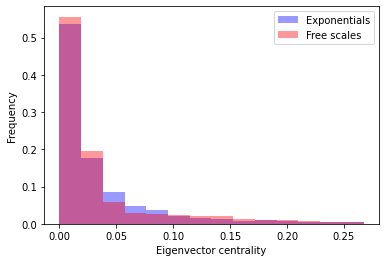

In [162]:
ERCentrality = [w for graph in exponentials for w in nx.eigenvector_centrality(graph, max_iter=1000, weight='weight').values()]
FSCentrality = [w for graph in freeScales for w in nx.eigenvector_centrality(graph, max_iter=1000, weight='weight').values()]
plt.xlabel('Eigenvector centrality')
plt.ylabel('Frequency')
drawOverlaidHistogram([(ERCentrality, 'blue', 'Exponentials'), (FSCentrality, 'red', 'Free scales')])

When looking at the eigenvector centrality of both kind of networks, we can see a similar shape. Most nodes (>70%) have a very low eigenvector centrality, and the curve tends to continualy decrease for increasing centrality. We can deduce that for both kind of networks, most of the nodes have either a low number of neighbors, or neighbors with a low strength. However, the exponentials networks having a higher mean eigenvector centrality means that nodes on these networks used to have either slightly more neighbors or stronger neighbors, or both, than those from free-scales networks.

# Part B: Analyzing Erdos-Renyi and Scale-Free graphs in both random error and target attack scenarios

## 1. Percolation threshold

In [163]:
def findPercolationThreshold(mat) -> float:
    """Return an approximation of the percolation threshold, as defined on
    the sixth equation of "Predicting percolation thresholds in networks" from
    Filippo Radicchi.

    The estimation is calculated as the inverse of the largest eigenvalue of the
    matrix M, where M is the 2Nx2N matrix composed of:
    1.1. The adjacency matrix of the graph
    1.2. The identity matrix minus the diagonal matrix created with the degree of
         the nodes
    2.1. The idendity matrix
    2.2. The null matrix
    
    See also https://cgi.luddy.indiana.edu/~filiradi/Mypapers/percolation_arxiv.pdf"""
    size = len(mat)
    M = np.bmat([
        [mat,                   np.identity(size) - np.diag([sum(row) for row in mat.A])],
        [np.identity(size),     np.zeros((size,size))]
    ])
    eigenvalues = np.linalg.eigvalsh(M)
    return 1/eigenvalues[-1]

### Explanation
Estimate the percolation thresholds for a given adjacency matrix following the equation proposed by Filippo Radicchi on their paper *Predicting percolation thresholds in networks*. They propose three formulas to estimate the percolation thresholds, while the one I choose is the one considered the more accurate.
$$ f_c = [ \substack{\small \max \\ \vec{w}} \frac{\vec{w}^T M \vec{w}}{\vec{w}^T \vec{w}} ]^{-1} $$
It is calculated as the inverse of the largest eigenvalue of the matrix $M$, defined as $ \small \begin{pmatrix} A & \mathbb{1}-D \\ \mathbb{1} & \mathbb{0} \end{pmatrix} $, where $A$ is the given adjacency matrix and $D$ is the diagonal matrix built using the degree of each nodes. As a remainder, $\frac{\vec{w}^T M \vec{w}}{\vec{w}^T \vec{w}}$ let us calculate the eigenvalue associated with the eigenvector $w$ of the matrix $M$. It is specify on the mentionned paper that the largest eigenvalue of this matrix $M$ is the same as the one from the non-backtracking, or Hashimoto, matrix.

For further informations, please refer to the original paper, available https://cgi.luddy.indiana.edu/~filiradi/Mypapers/percolation_arxiv.pdf.


## 3. Largest connected component

In [164]:
def largestConnectedComponent(mat):
    def getBiggestComponent(mat):
        "Get the list of nodes composing the biggest component of the network"
        nodes = []
        component = []
        # We iterate through the network until all nodes have been checked
        while len(nodes) < len(mat):
            node = 0
            # We check for the first node still unvisited
            while node in nodes: node += 1
            nodes.append(node)
            queue = [node]
            comp = [node]
            # And we visit it, as well as every neighbors of it
            while len(queue) > 0:
                for neighbors in range(0, len(mat)):
                    # If a node is connected to the current node and has not yet been visited, we add it to the list of node to visit
                    if mat[queue[0],neighbors] > 0 and neighbors not in nodes:
                        nodes.append(neighbors)
                        queue.append(neighbors)
                        comp.append(neighbors)
                # We remove the current node to the list of node to visit
                queue.pop(0)
            # If the current component is bigger than the previous biggest, we update it
            if len(comp) > len(component):
                component = comp
        return component

    # Get the list of nodes composing the biggest component and sort them
    component = getBiggestComponent(mat)
    component.sort()

    size = len(component)
    # Creating the submatrix, with only the nodes from the biggest component, while keeping the current connection
    subMat = np.matrix([[mat[row,col] for col in component] for row in component])
    # Getting the list of all pairs shortest paths. Iteration through the lower part of the matrix composing the distance
    distances = dict(nx.all_pairs_dijkstra_path_length(nx.from_numpy_matrix(subMat), weight='weight'))
    distance = [distances[row][col] for row in range(1, size) for col in range(0, row)]

    # Return the matrix of the biggest component, the number of element in it and the mean distances between nodes
    return (subMat, len(component), sum(distance) / len(distance) if len(distance) > 0 else 0)

### Explanation
In order to find the largest component, we are iterating through all nodes following a breadth first algorithm. When we find a node which hasn't been visited yet, we create a new component with it and then look for its neighborhood. Every nodes not already visited neighbor to the current node are added to the component. When every node of the component have been checked, we compare the current component with the previous biggest one, and override it if the new one is bigger.

Once we found the nodes composing the biggest component, we can create its submatrix by retrieving rows and columns from the original matrix whose both indexes are included on the component.
The mean distance is calculated with Dijkstra's All Pair Shortest Path algorithm. Then we retrieve all unique path, and divide their sum by the number of unique path.

## 5. Random error

In [165]:
def randomError(mat, errorFrequency):
    removed = []
    # Looking for nodes to remove, until the number of removed node exceed the required frequency
    while len(removed) / len(mat) < errorFrequency:
        while True:
            # Selecting a random node and adding it to the list of removed if not already on it
            node = random.randint(0, len(mat)-1)
            if node not in removed:
                removed.append(node)
                break

    # Duplicating the matrix while excluding the nodes that have been marked as being removed
    subMat = np.matrix([[mat[row,col] for col in range(len(mat)) if col not in removed] for row in range(len(mat)) if row not in removed])
    return subMat

### Explanation
We first randomly select nodes which havn't already been selected and we add them to the list of node to remove. Once the number of node to remove is greater than the require frequency, we duplicate the current matrix, while ignoring rows and columns which are included on the list of removed nodes.

## 6. Target attack

In [166]:
def targetAttack(mat, attackFrequency):
    removed = []
    # Getting the strength of each nodes, sorted by node index
    strengths = [sum(row) for row in mat.A]
    # Creating a new list of strength sorted by decreasing strength
    strengthsSorted = [*strengths]
    strengthsSorted.sort(reverse=True)
    # Looking for nodes to remove, until the number of removed node exceed the required frequency
    while len(removed) / len(mat) < attackFrequency:
        node = -1
        while True:
            # Selecting the next node with the highest strength. If already on the list, looking for the next one with the same strength
            node = strengths.index(strengthsSorted[len(removed)], node+1)
            if node not in removed:
                removed.append(node)
                break

    # Duplicating the matrix while excluding the nodes that have been marked as being removed
    subMat = np.matrix([[mat[row,col] for col in range(len(mat)) if col not in removed] for row in range(len(mat)) if row not in removed])
    return subMat

### Explanation
We first get the strength of each nodes, and sort it. Then we selected the node with the highest strength not already on the list of removed nodes in order to add it on. Once the number of node to remove is greater than the require frequency, we duplicate the current matrix, while ignoring rows and columns which are included on the list of removed nodes.

## 7. Analysis of diameter

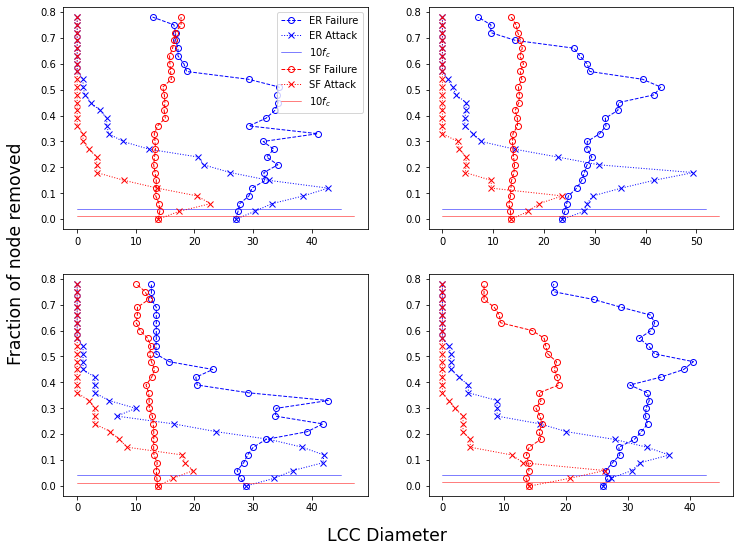

In [167]:
def displayDiameterWhileRemoving(mat, formats, labels=(None,None), frequency=0.03, maximumFrequency=0.8):
    erroredMat = mat.copy()
    attackedMat = mat.copy()
    erroredD = []
    attackedD = []
    iteration = math.ceil(maximumFrequency / frequency)
    for i in range(iteration):
        # In order to reach a frequency of e.g. 0.1, we must remove accordingly to the already removed nodes
        # If we need 90% of the network, while we have 95% of the original one, we must not remove 5% but rather 5.26%
        erroredMat = randomError(erroredMat, (1 - (1-i*frequency) * len(mat) / len(erroredMat)) if i > 0 else 0)
        (submat, size, diameter) = largestConnectedComponent(erroredMat)
        erroredD.append(diameter)
        attackedMat = targetAttack(attackedMat, (1 - (1-i*frequency) * len(mat) / len(attackedMat)) if i > 0 else 0)
        (submat, size, diameter) = largestConnectedComponent(attackedMat)
        attackedD.append(diameter)
    plt.plot(erroredD, [frequency*i for i in range(iteration)], formats[0], label=labels[0], linewidth=1, fillstyle='none')
    lines = plt.plot(attackedD, [frequency*i for i in range(iteration)], formats[1], label=labels[1], linewidth=1, fillstyle='none')
    pc = findPercolationThreshold(mat)
    plt.plot([0,plt.gca().get_xlim()[1]], [pc,pc], linewidth=0.5, color=lines[0].get_color(), label='$10 f_c$')

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(12,9))
fig.supxlabel('LCC Diameter', y=0.05, size='xx-large')
fig.supylabel('Fraction of node removed', x=0.06, size='xx-large')
plt.sca(ax0)
displayDiameterWhileRemoving(nx.to_numpy_matrix(randomSamplesER[0]), ('ob--','xb:'), ('ER Failure','ER Attack'))
displayDiameterWhileRemoving(nx.to_numpy_matrix(randomSamplesSF[0]), ('or--','xr:'), ('SF Failure','SF Attack'))
plt.legend()
plt.sca(ax1)
displayDiameterWhileRemoving(nx.to_numpy_matrix(randomSamplesER[1]), ('ob--','xb:'))
displayDiameterWhileRemoving(nx.to_numpy_matrix(randomSamplesSF[1]), ('or--','xr:'))
plt.sca(ax2)
displayDiameterWhileRemoving(nx.to_numpy_matrix(randomSamplesER[2]), ('ob--','xb:'))
displayDiameterWhileRemoving(nx.to_numpy_matrix(randomSamplesSF[2]), ('or--','xr:'))
plt.sca(ax3)
displayDiameterWhileRemoving(nx.to_numpy_matrix(randomSamplesER[3]), ('ob--','xb:'))
displayDiameterWhileRemoving(nx.to_numpy_matrix(randomSamplesSF[3]), ('or--','xr:'))
plt.show()

### Conclusion
As we can see on the above plots, the diameter for exponentials networks tends to continually increase when under random failure, and drops whenever the network is fragmented, between 60% and 70% of node removed. Under attack, it used to follow the diameter of random attack for the first 10% of node removal, and quickly increases up to 30%, where it drastically drops, indicating the beginning of the fragmentation of the network.

The scale-free networks, on the other side, used to keep a constant diameter under random error, but suffers a quick and short increases under attack, before beginning to collapse around 10% of node removal, and being completely fragmented around 35%.

Comparing these results with some from *Error and attack tolerance of complex networks* is rather limited, as there is only data for the first 5%. However for these percents, we can conclude we have the same results, as exponentials networks have an equally increasing diameter on both situation, while the scale-free networks are constants under random failure and quicly increasing under attack.

## 9. Analysis of size

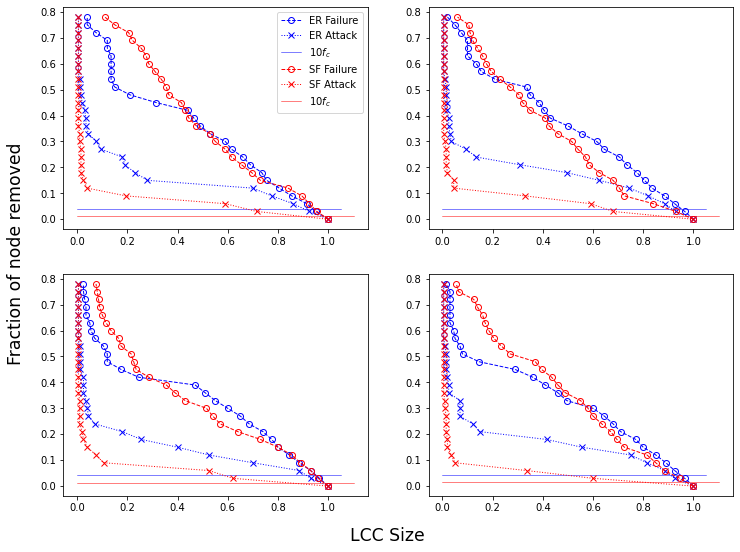

In [168]:
def displaySizeWhileRemoving(mat, formats, labels=(None,None), frequency=0.03, maximumFrequency=0.8):
    erroredMat = mat.copy()
    attackedMat = mat.copy()
    erroredS = []
    attackedS = []
    iteration = math.ceil(maximumFrequency / frequency)
    for i in range(iteration):
        erroredMat = randomError(erroredMat, (1 - (1-i*frequency) * len(mat) / len(erroredMat)) if i > 0 else 0)
        (submat, size, diameter) = largestConnectedComponent(erroredMat)
        erroredS.append(size / len(mat))
        attackedMat = targetAttack(attackedMat, (1 - (1-i*frequency) * len(mat) / len(attackedMat)) if i > 0 else 0)
        (submat, size, diameter) = largestConnectedComponent(attackedMat)
        attackedS.append(size / len(mat))
    plt.plot(erroredS, [frequency*i for i in range(iteration)], formats[0], label=labels[0], linewidth=1, fillstyle='none')
    lines = plt.plot(attackedS, [frequency*i for i in range(iteration)], formats[1], label=labels[1], linewidth=1, fillstyle='none')
    pc = findPercolationThreshold(mat)
    plt.plot([0,plt.gca().get_xlim()[1]], [pc,pc], linewidth=0.5, color=lines[0].get_color(), label='$10 f_c$')


fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(12,9))
fig.supxlabel('LCC Size', y=0.05, size='xx-large')
fig.supylabel('Fraction of node removed', x=0.06, size='xx-large')
plt.sca(ax0)
displaySizeWhileRemoving(nx.to_numpy_matrix(randomSamplesER[0]), ('ob--','xb:'), ('ER Failure','ER Attack'))
displaySizeWhileRemoving(nx.to_numpy_matrix(randomSamplesSF[0]), ('or--','xr:'), ('SF Failure','SF Attack'))
plt.legend()
plt.sca(ax1)
displaySizeWhileRemoving(nx.to_numpy_matrix(randomSamplesER[1]), ('ob--','xb:'))
displaySizeWhileRemoving(nx.to_numpy_matrix(randomSamplesSF[1]), ('or--','xr:'))
plt.sca(ax2)
displaySizeWhileRemoving(nx.to_numpy_matrix(randomSamplesER[2]), ('ob--','xb:'))
displaySizeWhileRemoving(nx.to_numpy_matrix(randomSamplesSF[2]), ('or--','xr:'))
plt.sca(ax3)
displaySizeWhileRemoving(nx.to_numpy_matrix(randomSamplesER[3]), ('ob--','xb:'))
displaySizeWhileRemoving(nx.to_numpy_matrix(randomSamplesSF[3]), ('or--','xr:'))
plt.show()

### Conclusion
We can see on the analyse of the size that both type of networks tends to keep a constant size under random error, while they both have a sudden drop of size, up to an almost null one at some given point. We can see that the drop occured with the first node removed for scale free networks, and stabilize around 15% of node removal, while the exponentials networks begin their fragmentation around 20%, up to 40% of node removed.

When we compare these reults with those from the paper, we can see some analogies and differences. Namely, the scale-free networks behave similarly, even if we seems to lack the total fragmentation around for random failure 80%. However, results from the exponentials networks are completely differents for random error. Indeed, while the paper announce a drop similar to the one under attack, we can't observe any drop on our case.

## 11. Percolation threshold comparison

As we can see on the previous graphs, the calculated percolations thresholds do not match with the moment the network is collapsing. A naive hypothesis would be that the calculated one is 10 times smaller than those observed, however some extra tests with more connected networks gave a smaller percolation thresholds, while a much bigger one wer observed.

Therefore, I can express three more hypothesis:
 * The function used to calculated the percolation thresold, *findPercolationThreshold*, is invalid
 * There are some problems with the *targetAttack* and *randomError* functions, leading to invalid graphs
 * Both the calcul and the graphs are correct, but do not demonstrate the same percolation thresholds

I would like to say that the calculs are correct, but rather denotes the moment at which networks are connected, when beginning with a totaly fragmented network. This seems to be coherent with the fact that scale free networks have a higher size than exponentials networks when a low number of nodes remains, that is on the upper part of the y-axis.

Anyway, what we can conclude with all these observations, is that scale free networks tends to be resistant to random error, with an almost static diameter and a constantly decreasing size. However, it is really weak to attacks, as it tends to fall apart when less than 10% of the network is targeted.

On the other side, exponentials networks are quite resilient to error, as the network doesn't seems to fragment neither quickly nor strongly, but the communication become much harder. Considering its resistance to attack, it is much better than scale free networks, as 30% of the network need to be targeted in order to the network to fall.